## New structure

### Practical
1. Read data
2. Process data
     - Double digit replacement
     - Compute longest (& shortest) smiles
3. Python implementation
     - One-hot encode (padding=True)
     - Visualization
          - Shortest smiles
          - Longest smiles 
4. Supplementary material or Other implementations (depending of the length of the notebook)
   - Scikit learn implementation
   - Keras implementation


## Practical

### Import necessary packages

In [1]:
from pathlib import Path
from warnings import filterwarnings
from timeit import default_timer as timer

import pandas as pd
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Silence some expected warnings
filterwarnings("ignore")

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Read data

Using the `pandas` library, we first load the subset of the ChEMBL dataset and draw the molecules using the `rdkit.draw` function. We then python implementations of `one-hot encoding` to the SMILES structures.

Let's load the data and quickly analyze its column values and check if there are any missing values:

In [3]:
df = pd.read_csv(DATA/'CHEMBL25_activities_EGFR.csv',
                 lineterminator='\n', index_col=0)  # NBVAL_CHECK_OUTPUT
df=df.reset_index(drop=True)

In [4]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (3906, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         3906 non-null   object 
 1   IC50              3906 non-null   float64
 2   units             3906 non-null   object 
 3   canonical_smiles  3906 non-null   object 
            3906 non-null   float64
dtypes: float64(2), object(3)
memory usage: 152.7+ KB


In [5]:
# Look at the first 3 rows
df.head(3)  # NBVAL_CHECK_OUTPUT

,chembl_id,IC50,units,canonical_smiles,pIC50\r
0,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000


In [6]:
# select the columns which are necessary
df = df[['chembl_id', 'canonical_smiles']]

We can visualize the molecules with their ChEMBL ID using pandas tools and the `draw` method as shown below.

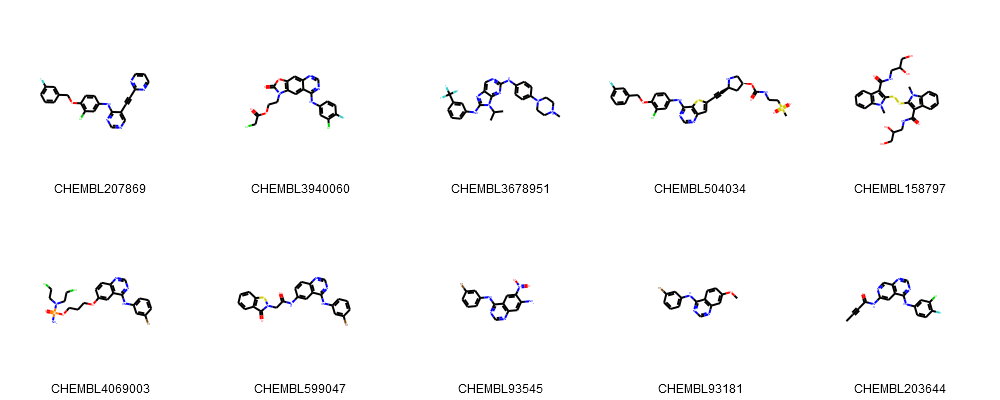

In [7]:
# Using pandas tools and the draw method
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='canonical_smiles', molCol='Mol2D' )
Draw.MolsToGridImage(list(df.Mol2D[0:10]),
                     legends=list(df.chembl_id[0:20]),
                     molsPerRow=5)  # NBVAL_CHECK_OUTPUT

### Process data

- SMILES strings could have unequal dimension since their string length might differ. For machine learning application, having equal dimension throughout the data set is required. In order to achieve this, we can first search for the SMILES string with the maximum length (e.g. [len()](https://www.geeksforgeeks.org/python-string-length-len/) method) and pass it as an argument in our function for all the strings.

- We searched for all the unique characters present in the SMILES data set which will allow us to remove the characters not present in the current data.

- As we know elements in the periodic table are represented by two characters, e.g. 'Cl' stands for chloride. This double-character phenomenon will be misinterpreted by the one hot encoding functions, i.e. it would split 'Cl' into two characters, namely 'C' and 'l', and that could lead to discrepancies, so searching for each unique character and encoding them may not be optimal. Hence, we suggest here to search for all double-character elements in our SMILES data set by comparing the atoms present in our strings with all the possible elements present in the periodic table and replacing all the two alphabetic elements with one character, for example changing 'Cl' to 'L'.

#### Double digit replacement

In [8]:
def assess_two_letter_elements(df):
    """
    Find the two letter elements in dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
       Dataframe which requires preprocessing.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements
    """
    # Search for unique characters in our SMILES strings
    unique_chars = set(df.canonical_smiles.apply(list).sum())
    upper_chars = [] 
    lower_chars = [] 
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f'Upper letter characters {upper_chars}')
    print(f'Lower letter characters {lower_chars}')
    
    # List of all possible periodic elements
    periodic_elements = ['Ac',
                         'Al', 'Am', 'Sb', 'Ar', 'As', 'At', 'Ba',
                         'Bk', 'Be', 'Bi', 'Bh', 'B', 'Br', 'Cd', 'Ca',
                         'Cf', 'C', 'Ce', 'Cs', 'Cl', 'Cr', 'Co', 'Cn',
                         'Cu', 'Cm', 'Ds', 'Db', 'Dy', 'Es', 'Er', 'Eu',
                         'Fm', 'Fl', 'F', 'Fr', 'Gd', 'Ga', 'Ge', 'Au',
                         'Hf', 'Hs', 'He', 'Ho', 'H', 'In', 'I', 'Ir',
                         'Fe', 'Kr', 'La', 'Lr', 'Pb', 'Li', 'Lv',
                         'Lu', 'Mg', 'Mn', 'Mt', 'Md', 'Hg', 'Mo',
                         'Mc', 'Nd', 'Ne', 'Np', 'Ni', 'Nh', 'Nb',
                         'N', 'No', 'Og', 'Os', 'O', 'Pd', 'P',
                         'Pt', 'Pu', 'Po', 'K', 'Pr', 'Pm', 'Pa',
                         'Ra', 'Rn', 'Re', 'Rh', 'Rg', 'Rb', 'Ru', 'Rf',
                         'Sm', 'Sc', 'Sg', 'Se', 'Si', 'Ag', 'Na',
                         'Sr', 'S', 'Ta', 'Tc', 'Te', 'Ts', 'Tb', 'Tl', 'Th',
                         'Tm', 'Sn',
                         'Ti', 'W', 'U', 'V', 'Xe', 'Yb', 'Y', 'Zn', 'Zr']

    # 'two_char_elements' is a list that contains two letter elements
    # which are valid when compared with all the possible periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if (ch in periodic_elements):
                two_char_elements.append(ch)

    # 'two_charc_elements_smiles' is a set that contains all the possible
    # two letter elements in our SMILES strings, that is specific to our dataset.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        for index in range(len(df)):
            if (df['canonical_smiles'].iloc[index].find(char) != -1):
                two_char_elements_smiles.add(char)
    return(two_char_elements_smiles)

In [9]:
elements_found = assess_two_letter_elements(df)
print(f'Two letter elements found in data set: {elements_found}')

Upper letter characters ['B', 'N', 'O', 'C', 'S', 'P', 'I', 'H', 'F']
Lower letter characters ['s', 'o', 'r', 'n', 'e', 'c', 'l']
Two letter elements found in data set: {'Cl', 'Sc', 'Se', 'Cn', 'Br'}


Based on this finding we defined our own dictionary for replacement. Note that
- We excluded *Sc* from replacement, since it is more likely that sulfur (S) and and aromatic carbon (c) are contained in a molecule than scandium (Sc).
- In isomeric SMILES `@` and `@@` are used to describe enantiomers, thus we also need to replace the latter by a one letter code.
- If you are working wit a different data set, you may want to adapt the below mapping dictionary.

In [10]:
# Dictionary to replace the two letter elements found
replace_dict ={'Cl':'L', 'Br':'R' ,'Cn':'X' , 'Se':'Z' , '@@':'$'}

In [11]:
# Function used to create the preprocessed data
def preprocessing_data(df, replacement):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
       Dataframe which requires preprocessing.
    replacement : dict
       Dictionary with mapping for replacement.
       
    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new processed canonical SMILES column.
    unique_char : list
        List with unique characters present in SMILES.
    SMILES_maxlen : int
        Maximum length of SMILES string.
    """
    # Print warning if the dataset has a 'Sc' element
    for tmp_smiles in df.canonical_smiles:
        if (tmp_smiles.find('Sc') != -1): 
            print('**Warning**: "Sc" element is found in the dataset, since the element is rarely found '
                  'in the drugs so we are not converting  '
                  'it to single letter element, instead considering "S" '
                  'and "c" as seperate elements. ')
            break

    
    # Create a new column having processed canonical SMILES
    df['processed_canonical_smiles'] = ""

    # Replace the two letter elements found
    # with one character
    for index in range(len(df)):
        cur_smiles = df['canonical_smiles'].iloc[index]
        for key, value in replacement.items():
            cur_smiles = cur_smiles.replace(key,value)
        df['processed_canonical_smiles'].iloc[index] = cur_smiles
    
    # Calculate max length of the SMILES strings
    SMILES_maxlen = df["processed_canonical_smiles"].str.len().max()
    
    unique_char = set(df.processed_canonical_smiles.apply(list).sum())
    return unique_char, df, SMILES_maxlen

#### Compute longest (& shortest) smiles

In [12]:
# Index of the longest smile string
longest_smile = max(df["canonical_smiles"], key = len) 
longest_smile_index = df.canonical_smiles[df.canonical_smiles == longest_smile].index.tolist()
longest_smile_index

[2705]

In [13]:
# Index of the shortest smile string
shortest_smile = min(df["canonical_smiles"], key = len) 
shortest_smile_index = df.canonical_smiles[df.canonical_smiles == shortest_smile].index.tolist()
shortest_smile_index

[1176]

### Python implementation of one-hot encoding

#### One-hot encode (padding=True)

In [14]:
# Calling function
unique_char, df, SMILES_maxlen = preprocessing_data(df, replace_dict)

**Warning**: "Sc" element is found in the dataset, since the element is rarely found in the drugs so we are not converting  it to single letter element, instead considering "S" and "c" as seperate elements. 


In [15]:
# Function defined to create one-hot encoded matrix
def new_smiles_encoder(smiles, maxlen, uniquechar):
    """
    Function defined using all unique characters in our
    processed canonical smiles structures created
    from preprocessed function.

    Parameters
    ----------
    smiles : str
         SMILES data in string format.
    uniquechar : list
         list of unique characters in the string dataset.
    maxlen : int
         maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max smile length).
    """
    # create dictionary of the unique char dataset
    smi2index = dict((char, index) for index, char in enumerate(unique_char))
    # one hot encoding
    smiles_matrix = np.zeros((len(unique_char), maxlen))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."

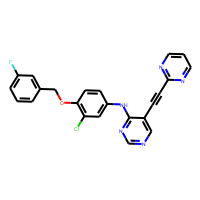
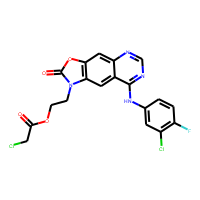
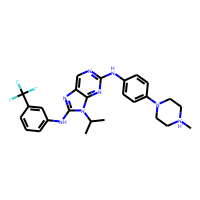

In [16]:
# Apply the function to the processed canonical SMILES strings
start = timer()
df['unique_char_ohe_matrix'] = df['processed_canonical_smiles'].apply(
                                  new_smiles_encoder, maxlen=SMILES_maxlen, 
                                  uniquechar=unique_char)
end = timer()
df.head(3)  # NBVAL_CHECK_OUTPUT

In [17]:
# Print time required for execution
smiles_encoder_equal_dim = end - start
print(f"Time to execute the function: "
      f"{smiles_encoder_equal_dim:.2f} secs")  

Time to execute the function: 0.23 secs


#### Visualization

In [18]:
def one_hot_matrix_plot(ohe_matrix, smiles_char, smiles):
    """
    Visualize one-hot encoded matrix
    using matplotlib imshow() function.

    Parameters
    ----------
    one_hot_matrix_plot : ndarray
       One-hot encoded (ohe) matrix of shape
       (`smiles_char`, `len(smiles)`).
    smiles_char : list
        list of all possible SMILES characters.
    smiles : string
        SMILES string of respective molecule        

    Returns
    ------
    None

    """
    im = plt.imshow(ohe_matrix, cmap='hot', interpolation='None')
    plt.xlabel('Length of SMILES string')
    plt.ylabel(f'Char in SMILES ({len(smiles_char)})')
    plt.title('Visualization of one-hot encoded matrix')
    plt.show()
    print('Shape of one-hot matrix : ', ohe_matrix.shape)
    print('Associated canonical SMILES: ', smiles)
    return None

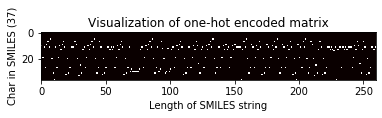

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  O=C(N[C@@H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C@@H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C@@H](CC(=O)N)C(=O)NCCCC1)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H]1N=C([C@@H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


In [19]:
# Pass the index of the longest smile string to visualize the matrix
one_hot_matrix_plot(df.iloc[longest_smile_index[0]]['unique_char_ohe_matrix'], unique_char, 
                    longest_smile)  # NBVAL_CHECK_OUTPUT

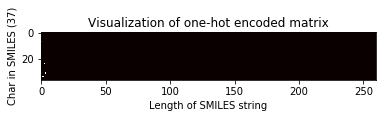

Shape of one-hot matrix :  (37, 260)
Associated canonical SMILES:  [Cl-]


In [20]:
# Pass the index of the shortest smile string to visualize the matrix
one_hot_matrix_plot(df.iloc[shortest_smile_index[0]]['unique_char_ohe_matrix'], unique_char, 
                    shortest_smile)  # NBVAL_CHECK_OUTPUT

From above, the matrix visualization was performed using matplotlib imshow() function, we can also visualize the entire matrix using the numpy.matrix function, e.g. the one-hot encoded matrix of the longest SMILES string as shown below.

In [23]:
# Print the some rows of the matrix for the longest smile
np.set_printoptions(threshold=np.inf)
subset=5
print(f'First {subset} rows of the ohe matrix, representing the charcters {unique_char[0:subset]}\n')
print(np.matrix(df.iloc[longest_smile_index[0]]['unique_char_ohe_matrix'])[0:subset, :])

TypeError: 'set' object is not subscriptable

## Discussion 

### Challenges 

There were several challenges faced during the task, for instance:

- Making equal dimensions of the one-hot encoded matrix.

- Replacing two letter elements with unique characters (note: the selected replacement might need to be extended for other datasets).

- After searching for two letter elements, we found a specific element `Sc` which is a metallic element. In our dataset both 'S' and 'c' elements are present individually as well. So if we would have replaced `Sc` with single a letter element then it might have effected our actual strings. So we assumed that since `Sc` is a metallic element and is rarely present in SMILES, we did not replace this element.

### Supplementary material 

#### Scikit-learn implementation of one-hot encoding

Before implementing one hot encoding using scikit-learn, we have defined the functions named later_padding which adds horizontal and vertical padding to the given matrix and initial_padding which adds zeros to the character list after they are label encoded by using the numpy.pad function as discussed in the theory section.

It is defined here because it will be used as a boolean parameter (islaterpadding and isinitialpadding) later in the scikit-learn and keras implementations to choose if later padding or initial padding is required or not.

In [ ]:
# Function to add padding after one-hot encoding
def later_padding(ohe_matrix, maxlen, uniquechar):
    """
    Add horizontal and vertical padding
    to the given matrix using numpy.pad() function.

    Parameters
    ----------
    ohe_matrix: ndarray
        Character array.
    smiles_max_len: int
        Maximum length of the SMILES string.
    unique_char: list
        List of unique characters in the string dataset.
            
    Returns
    -------
    padded_matrix: ndarray
           Padded one-hot encoded matrix of
           shape (unique char in smiles, max smile_length).
   """
    
    padded_matrix = np.pad(ohe_matrix, ((0, SMILES_maxlen-len(ohe_matrix)),
                                         (0, len(unique_char)-len(
                                          ohe_matrix[0]))), 'constant')
    return padded_matrix

In [ ]:
# Function to add padding before one-hot encoding
# after label (integer) encoding
def initial_padding(smiles, maxlen):
    """
    Add zeroes to the list of characters 
    after integer encoding them

    Parameters
    ----------
    smiles : str
       SMILES string.
    maxlen: int
       Maximum length of the SMILES string

    Returns
    -------
    ndarray
      One-hot encoded matrix with intial padding of shape
      (unique char in smiles, max smile_length).
    """
    canonical_char = list(smiles)
    # perform padding on the list of characters
    canonical_char_padded = np.pad(canonical_char, (0,
                         maxlen-len(canonical_char)), 'constant')
    return canonical_char_padded

In [ ]:
# Use Scikit-learn implementation of one-hot encoding
def sklearn_one_hot_encoded_matrix(smiles, islaterpadding, isinitialpadding):
    """
    Label and one-hot encodes the SMILES
    using sklearn LabelEncoder and OneHotEncoder implementation.
    
    Parameters
    ----------
    smiles : str
        SMILES string of a compound.
    islaterpadding : bool
        Paramater is `True` if `later_padding` is required,
        `False` otherwise.
    isinitialpadding : bool
        Paramater is `True` if `initial_padding` is required,
        `False` otherwise.
          
    Returns
    -------
    onehot_encoded : ndarray
        One-hot encoded matrix of shape
        (chars in individual SMILES, length of individual SMILES).
    """
    # Integer encoding
    canonical_char = list(smiles)
    label_encoder = LabelEncoder()
    # Fit_transform function is used to first fit the data and then transform it
    integer_encoded = label_encoder.fit_transform(canonical_char)
    
    if (isinitialpadding == True):
        integer_encoded = initial_padding(integer_encoded, SMILES_maxlen)
        
    # One-hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    if (islaterpadding == True):
        onehot_encoded = later_padding(onehot_encoded, SMILES_maxlen, unique_char)
    
    onehot_encoded = onehot_encoded.transpose()
    
    if (isinitialpadding == True):
        row_padding = np.ndarray(shape=(len(unique_char)-len(onehot_encoded),
                                    SMILES_maxlen,))
        row_padding.fill(0)
        onehot_encoded = np.append(onehot_encoded, row_padding, axis=0)
    return onehot_encoded

#### Without padding (unequal dimension)

We can use the `sklearn_one_hot_encoded_matrix` function defined above to create the one-hot encoded matrix and no padding is perfomed, it will create unequal dimensions of the matrix because it will first label encode all the characters present in the SMILES strings (individually) and then one-hot encode them.

In [ ]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_no_padding'] = df['processed_canonical_smiles'].apply(
                                          sklearn_one_hot_encoded_matrix, 
                                          islaterpadding=False, 
                                          isinitialpadding=False)
end = timer()
df.head(2) # NBVAL_CHECK_OUTPUT

#### With padding (equal dimension)
It can be either done after one-hot encoding is performed on the SMILES strings or before, meaning after we label encode the SMILES characters. We discuss both scenarios in the next sections.

##### Padding after one-hot encoding is performed

We simply pass **True** to the `islaterpadding` boolean parameter in `sklearn_one_hot_encoded_matrix` function as shown below to pad the matrix after one hot encoding is performed,

In [ ]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_later_padding'] = df['processed_canonical_smiles'].apply(
                                             sklearn_one_hot_encoded_matrix, 
                                             islaterpadding=True, isinitialpadding=False)
end = timer()
df.head(2) # NBVAL_CHECK_OUTPUT

##### Padding before one-hot encoding is performed

In this case, padding is performed after label or integer encoding the list of SMILES characters by passing **True** to the `initial_padding` boolean parameter in `sklearn_one_hot_encoded_matrix` function.

In [ ]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['sklearn_ohe_matrix_initial_padding'] = df['processed_canonical_smiles'].apply(
                                               sklearn_one_hot_encoded_matrix, 
                                               islaterpadding=False, 
                                               isinitialpadding=True)

end = timer()
df.head(2)

#### Keras implementation of one-hot encoding

In [ ]:
# Use keras implementation of one-hot encoding
def keras_one_hot_encoded_matrix(smiles, islaterpadding, maxlen, uniquechar):
    """
    One-hot encodes the SMILES using keras
    implementation.
    
    Parameters
    ----------
    canonical_char : array
        Canonical character array.
    islaterpadding : bool
        The paramater is `True` if later_padding is required,
        `False` otherwise.
    maxlen: int
        Maximum length of the SMILES string.
    uniquechar: list
        List of unique characters in the string dataset.
        
    Returns
    -------
    encoded : ndarray
        One-hot encoded matrix of shape
        (chars in SMILES, length of SMILES).
    """
   
    # Integer encoding using Tokenizer
    input = smiles
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts([input])
    integer_encoded = tokenizer.texts_to_sequences([input])[0]
    
    # One-hot encoding using to_categorical function
    encoded = to_categorical(integer_encoded)
    if (islaterpadding == True):
        encoded = later_padding(encoded, SMILES_maxlen,unique_char)
    encoded = encoded.transpose()
    return encoded

Next, we will implement two scenarios, 

- one, when there is no later padding performed which will result in unequal dimensions of the produced one-hot encoded matrix and 
- the other, where later padding will be performed by passing `True` to the boolean parameter `islaterpadding` in the `keras_one_hot_encoded_matrix` function.

#### Without padding (unequal dimension)

In [ ]:
# Apply the function over the processed canonical SMILES strings
start = timer()
df['keras_ohe_matrix_without_padding'] = df['processed_canonical_smiles'].apply(
                                            keras_one_hot_encoded_matrix, 
                                            maxlen = SMILES_maxlen, 
                                            uniquechar = unique_char, 
                                            islaterpadding=False)
end = timer()
df.head(2)

#### With padding (equal dimension)

In [ ]:
# Apply the function over the Processed_canonical_smiles strings
start = timer()
df['keras_ohe_matrix_padding'] = df['processed_canonical_smiles'].apply(
                                    keras_one_hot_encoded_matrix, 
                                    maxlen = SMILES_maxlen,
                                    uniquechar = unique_char, 
                                    islaterpadding=True)
end = timer()
df.head(2)